>>>[5.1 Trivial Implementation](#folderId=1NMmMD5RX97aCsXDtRdiTFytxzVFeGSnW&updateTitle=true&scrollTo=-TLcDZv9QLDV)
>>>[5.3 Analyzing the Algorithm](#folderId=1NMmMD5RX97aCsXDtRdiTFytxzVFeGSnW&updateTitle=true&scrollTo=jnDBhClMVdlo)
>>>>[How is the length of the inout message affecting the speed of encrypting and decrypting?](#folderId=1NMmMD5RX97aCsXDtRdiTFytxzVFeGSnW&updateTitle=true&scrollTo=bNram5eGVnEZ)


In [1]:
import random
import math
import requests
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

%run "source/RSA Helper Functions.ipynb"

To better understand the practical application of the theoretical principles we've discussed, let's walk through the key generation, encryption, and decryption processes involved in the RSA algorithm. For the sake of clarity, we'll use small numbers as the previous math example.

### 5.1 Trivial Implementation

First let's prepare the functions that will be needed to perform the 5 steps of the key generation process.

#### Generate prime numbers

In [2]:
def is_prime (number):
    if number < 2:
        return False
    for i in range (2, number // 2 + 1):
        if number % i == 0:
            return False
    return True

def get_random_number(n_bits):
    return random.randrange(2**(n_bits-1) + 1, 2**n_bits - 1)

def generate_prime(n_bits):
    while True:
        prime = get_random_number(n_bits)
        if is_prime(prime):
            return prime

#### Generate $\varphi(n)$

In [3]:
def eulers_totient(p, q):
    return (p-1) * (q-1)

#### Generate public exponent $e$

In [4]:
def generate_public_exponent(phi_n):
    e = random.randint (3, phi_n-1)
    while math.gcd(e, phi_n) != 1:
        e = random.randint (3, phi_n - 1)

    return e

#### Calculate the modular inverse $d$

In [5]:
def mod_inverse(e, phi):
    for d in range (3, phi):
        if (d * e) % phi == 1:
            return d
    raise ValueError (f"mod_inverse of ({e}, {phi}) does not exist!")

#### Generate keys

Now let's combine the above functions to generate the public and private keys. The function `generate_keys()` will also return $n$, which will be used in subsequent encryption/decryption.

In [6]:
def generate_keys(p = None, q = None, e = None, prime_length_bits = 8):
    # Step 1: Generate primes
    if ((not p) or (not q)):
        p, q = generate_prime(prime_length_bits), generate_prime (prime_length_bits)
        if p == q:
            q = generate_prime (prime_length_bits)
    else:
        if (not is_prime(p) or not is_prime(q)):
            pass

    # Step 2: Generate the product of the primes
    n = p * q

    # Step 3: Generate φ(n)
    phi_n = eulers_totient(p, q)

    # Step 4: Generate the public exponent e
    if (not e):
        e = generate_public_exponent(phi_n)

    # Step 5: Calculate the modular inverse d
    d = mod_inverse(e, phi_n)

    return e, d, n

#### Encrypt/Decrypt the message

In [7]:
def encrypt_message_to_cipher(M, e, n):
    M_ascii_encoded = [ord(ch) for ch in M]
    cipher = [pow(ch, e, n) for ch in M_ascii_encoded]

    return cipher

def decrypt_cipher_to_message(C, d, n):
    C_ascii_encoded = [pow(ch, d, n) for ch in C]
    M = "".join (chr(ch) for ch in C_ascii_encoded)

    return M

#### Combining all components

In [8]:
e, d, n = generate_keys()

message = "A"
encrypted = encrypt_message_to_cipher(message, e, n)
decrypted = decrypt_cipher_to_message(encrypted, d, n)

print ("Public Key:  ", e)
print ("Private Key: ", d)
print ("n:           ", n)
print ("Original message:  ", message)
print ("Encrypted by RSA   ", encrypted)
print ("Decrypted message: ", decrypted)

Public Key:   29847
Private Key:  3079
n:            40309
Original message:   A
Encrypted by RSA    [13109]
Decrypted message:  A


#### Unit tests

Now is a good time to write some tests so that we know we haven't broken our implementation with future changes of the code.

In [9]:
def test_decrypting(message):
    e, d, n = generate_keys()
    encrypted = encrypt_message_to_cipher(message, e, n)
    decrypted = decrypt_cipher_to_message(encrypted, d, n)
    assert decrypted == message, "The decrypted message is not the same as the original message!"

def all_unit_tests(messages):
    for message in messages:
        test_decrypting(message)

    print("\033[32m ✅ All tests passed \033[0m")

In [10]:
file_6000_chars = Path("test_data/file_6000_chars.txt").read_text()

all_unit_tests(["A", "AB", "Hello and welcome to Sofia!", file_6000_chars])

 ✅ All tests passed 


### 5.2 Analyzing the Algorithm

In this section, we will explore the impact of modifying various parameters involved in the RSA algorithm, particularly focusing on how these changes affect 🔴 security and performance.

#### 5.2.1 How the size of $p$ and $q$ affects the time for their generation?

##### Explore the time to generate prime numbers of varying lengths using brutre force prime generation

Let's explore the time required to generate prime numbers of varying lengths. We will generate specific primes by constraining the range to the desired prime. The current algorithm in function `generate_prime()` we created above (🔴link to section ) employs a brute-force approach, generating a random number within a specified range and then checking its primality using a brute-force method.

In [11]:
# function 'mean_time_msec' is defined in the companion notebook RSA Helper Functions.ipynb
def test_prime_generation_performance(n_bits_list, fn_generate_prime):
    return  [mean_time_msec(1)(fn_generate_prime)(n_bits) for n_bits in n_bits_list]

<div class="alert alert-block alert-warning" style="font-size:1.2em">
⚠️The below cell will run for $≈$3 min. If you want to run it set the flag to True. Otherwise you can inspect the output in the screenshot below the cell.
</div>

In [12]:
I_UNDERSTAND_THE_CELL_WILL_RUN_LONG_TIME = False

if I_UNDERSTAND_THE_CELL_WILL_RUN_LONG_TIME:
    n_bits_list = [5, 10, 20, 25, 27, 30]
    print(test_prime_generation_performance(n_bits_list, generate_prime))

Output of the above cell:

![generate_primes_brute_force.png](images/generate_primes_brute_force.png)

Generating a 30 bit prime number using the brute-force method took $≈$ 33 seconds. Clearly a performance hog! Let's try to improve the performance by using another algorithm like the Sieve of Eratosthenes.

##### Try to improve prime generation by using the Sieve of Eratosthenes

In [13]:
I_UNDERSTAND_THE_CELL_WILL_RUN_LONG_TIME = False

# functions 'generate_prime_sieve_eratosthenes' and 'mean_time_msec' are defined in the companion notebook RSA Helper Functions.ipynb
if I_UNDERSTAND_THE_CELL_WILL_RUN_LONG_TIME:
    n_bits_list = [5, 10, 20, 25, 27, 30]
    print(test_prime_generation_performance(n_bits_list, generate_prime_sieve_eratosthenes))

Output of the above cell:
![generate_primes_sieve_er.png](images/generate_primes_sieve_er.png)

Generating a 30-bit prime number using the Sieve of Eratosthenes took 221 seconds. This is much worse performance. However, this is expected because the Sieve of Eratosthenes is designed to generate a list of all prime numbers up to a given limit, whereas in this case, we only needed one prime number within that range. As a result, the algorithm performed more work than was necessary to achieve the desired outcome, leading to the longer execution time.

##### Another improvement attempt by using the Miller-Rabin Primality test

Let's make another attempt to improve the prime generation by using the Miller-Rabin primality test instead of the brute force `is_prime()`. This algorithm can produce false positives that is why it is executed multiple times to increase the probability of a correct result.

In [14]:
def generate_prime_miller_rabin(n_bits):
    while True:
        prime = get_random_number(n_bits)
        if is_prime_miller_rabin(prime, k=5):
            return prime

In [15]:
I_UNDERSTAND_THE_CELL_WILL_RUN_LONG_TIME = False

if I_UNDERSTAND_THE_CELL_WILL_RUN_LONG_TIME:
    n_bits_list = [256, 516, 1024, 2048, 4096]
    print(test_prime_generation_performance(n_bits_list, generate_prime_miller_rabin))

Output of the above cell:
![generate_primes_miller_rabin.png](images/generate_primes_miller_rabin.png)

We see that even though we saw good times for generation of small and mid-sized primes, even the Miller-Rabin algorithm fails in terms of performance for 2048-bit primes. Let's make one more attempt at improving performance by combining the Sieve or Eratosthenes and the Rabin-Miller primality test. The idea is to generate less prime candidates by first excluding the non-primes using the sieve.

##### Yet another attempt to improve performance by combining the Sieve of Eratosthenes and the Rabin-Miller primality test

In [16]:
def generate_prime_miller_rabin_sieve_er (n_bits):
    while True:
        prime_candidate = get_random_number_sieved(n_bits)
        if not is_prime_miller_rabin(prime_candidate, k=5):
            continue
        else:
            return prime_candidate

In [17]:
I_UNDERSTAND_THE_CELL_WILL_RUN_LONG_TIME = False
# function 'is_prime_miller_rabin_sieve_er' is defined in the companion notebook RSA Helper Functions.ipynb

if I_UNDERSTAND_THE_CELL_WILL_RUN_LONG_TIME:
    n_bits_list = [256, 516, 1024, 2048, 4096]
    print(test_prime_generation_performance(n_bits_list, generate_prime_miller_rabin_sieve_er))

Output of the above cell:
![generate_primes_rabin_miller_sieve_er.png](images/generate_primes_rabin_miller_sieve_er.png)


Finally, we have enough information to compare the time for generating prime numbers of different lengths using two algorithms:

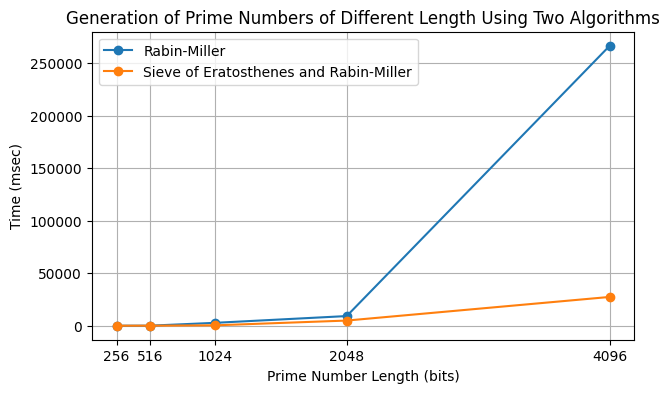

In [18]:
n_bits_list = [256, 516, 1024, 2048, 4096]
times_to_generate_prime_mr = [23.704800001723925, 59.54100000235485, 2779.947099999845, 9221.19549999843, 266755.3584999987]
times_to_generate_prime_mr_sieve = [17.45451996102929, 61.99582004919648, 398.5925999470055, 4936.42343999818, 27441.254119947553]

plt.figure(figsize=(7, 4))
plt.plot(n_bits_list, times_to_generate_prime_mr, marker="o", label="Rabin-Miller")
plt.plot(n_bits_list, times_to_generate_prime_mr_sieve, marker='o', label="Sieve of Eratosthenes and Rabin-Miller")
plt.xlabel("Prime Number Length (bits)")
plt.ylabel("Time (msec)")
plt.title("Generation of Prime Numbers of Different Length Using Two Algorithms")
plt.xticks(n_bits_list)
plt.legend()
plt.grid(True)
plt.show()

##### Run functional tests with the new generate_prime

Now that we've enhanced the efficiency of generating a prime number, let's execute the functional tests again to verify that the core functionality remains 
 uncompromised.

In [19]:
generate_prime = generate_prime_miller_rabin_sieve_er
all_unit_tests(["A", "AB", "Hello and welcome to Sofia!", file_6000_chars])

 ✅ All tests passed 


#### 5.2.2 What is the effect of RSA key length on the private exponent $d$ generation time?

In RSA cryptography, the term "key size" refers to the length (in bits) of the modulus $n$. For instance, if we want a 2048-bit key size, we would need to generate two prime numbers, each approximately 1024 bits long, and then multiply them to obtain the modulus n.

However, the actual RSA keys used for encryption and decryption are the public exponent $e$ and the private exponent $d$, respectively. The key size (i.e., the bit length of $n$) determines the difficulty of factoring n to derive the private key d from the public key $e$.

Now, let's explore how the time required to generate the public-private key pair scales with the key size.

##### Explore the time to calculate the modular inverse using brute force

In [20]:
def get_time_to_calculate_d(e, key_length, fn_mod_inverse):
    prime_length = key_length // 2
    attempt = 0
    time_to_calculate_d = 1
    # sometimes the random primes lead to no modular inverse of e so we keep trying with other primes
    while attempt < 5:
        try:
            p, q = generate_prime_miller_rabin_sieve_er(prime_length), generate_prime_miller_rabin_sieve_er(prime_length)
            phi_n = eulers_totient(p, q)
            time_to_calculate_d = mean_time_msec(5)(fn_mod_inverse)(e, phi_n)
            break
        except Exception as exception:
            attempt += 1
            print(exception)
    if (attempt >= 5):
        raise Exception("After 5 tries did not find mod_inverse of {e}")

    return time_to_calculate_d

In [21]:
e = 65537
key_lengths = [16, 18, 20, 22, 24, 26, 28]

times_to_calculate_d = [get_time_to_calculate_d(e, key_length, mod_inverse) for key_length in key_lengths]
print(*[f"Key size: {key_bits}, time to calculate d: {round(time_d, 2)} msec" for key_bits, time_d in zip(key_lengths, times_to_calculate_d)], sep='\n')

Key size: 16, time to calculate d: 4.94 msec
Key size: 18, time to calculate d: 13.71 msec
Key size: 20, time to calculate d: 37.49 msec
Key size: 22, time to calculate d: 251.54 msec
Key size: 24, time to calculate d: 134.75 msec
Key size: 26, time to calculate d: 2193.69 msec
Key size: 28, time to calculate d: 4334.78 msec


When we examine the times required to calculate the inverse, it becomes evident that there is an issue. For a key size of 28 bits, the calculation of the private exponents already takes 7-8 seconds. This approach is not scalable for key sizes of 1024 and 2048 bits. 
The reason behind this poor performance is that in the section "5.1 Trivial Implementation" (🔴LINK) we implemented the calculation of the modular inverse using a brute-force method. Let's explore whether utilizing the Extended Euclidean Algorithm can enhance the performance.

##### Try to improve the calculation of modular inverse by using the Extended Eucliean Algorithm

In [22]:
def extended_gcd(a, b):
    """The extended Euclidean algorithm."""
    if a == 0:
        return b, 0, 1
    else:
        gcd, x1, y1 = extended_gcd(b % a, a)
        x = y1 - (b // a) * x1
        y = x1
        return gcd, x, y

def mod_inverse_extended_euclidean(e, phi):
    """Compute the modular inverse of e modulo phi."""
    gcd, x, y = extended_gcd(e, phi)
    if gcd != 1:
        raise ValueError(f"No modular inverse for e={e} and phi={phi}")
    else:
        return x % phi


In [23]:
key_lengths = [16, 18, 20, 22, 24, 26, 28]
times_to_calculate_d = [get_time_to_calculate_d(e, key_length, mod_inverse_extended_euclidean) for key_length in key_lengths]
print(*[f"Key size: {key_bits}, time to calculate d: {round(time_d, 4)} msec" for key_bits, time_d in zip(key_lengths, times_to_calculate_d)], sep='\n')

Key size: 16, time to calculate d: 0.0045 msec
Key size: 18, time to calculate d: 0.0027 msec
Key size: 20, time to calculate d: 0.0032 msec
Key size: 22, time to calculate d: 0.0029 msec
Key size: 24, time to calculate d: 0.0028 msec
Key size: 26, time to calculate d: 0.0028 msec
Key size: 28, time to calculate d: 0.0029 msec


With notable progress achieved, we can now explore the utilization of more extended key lengths.

In [24]:
e = 65537
key_lengths = [256, 512, 1024, 2048, 3072, 4096]
times_to_calculate_d = [get_time_to_calculate_d(e, key_length, mod_inverse_extended_euclidean) for key_length in key_lengths]
print(*[f"Key size: {key_bits}, time to calculate d: {round(time_d, 4)} msec" for key_bits, time_d in zip(key_lengths, times_to_calculate_d)], sep='\n')

Key size: 256, time to calculate d: 0.0073 msec
Key size: 512, time to calculate d: 0.0059 msec
Key size: 1024, time to calculate d: 0.0058 msec
Key size: 2048, time to calculate d: 0.0042 msec
Key size: 3072, time to calculate d: 0.0065 msec
Key size: 4096, time to calculate d: 0.0058 msec


From the output we see that while the key size increases by a factor of 16, the time to calculate $d$ increases sub-linearly only by a factor of 2. Furthermore, $d$ calculation times of a micorseconds shows that the Extended Euclidean algorithm is very efficient.

##### Run functional tests with the new mod_inverse

In [25]:
mod_inverse = mod_inverse_extended_euclidean
all_unit_tests(["A", "AB", "Hello and welcome to Sofia!", file_6000_chars])

 ✅ All tests passed 


#### 5.2.3 What is the impact of $e$'s length on $d$'s generation time?

Now that we know the modular inverse calculation is very fast even for 4096 bit keys we can run a combined performance test for various lengths of the public exponent $e$ and RSA key lengths. 

##### Performance test for various lengths of $e$

The value of $e$ needs to satisfy two conditions: it must be greater than 1 and less than $\varphi(n)$, and it must be coprime with $\varphi(n)$, meaning their greatest common divisor is 1. By choosing the maximum length for $e$ to be equal to that of $p$, we ensure that these conditions are met. For the performance test let's choose 4 values of $e$ depending on the prime number length (which is about one half of the RSA key length): a quarter the length of the prime, one half, tree quarters and the length of the prime.

In [26]:
# this cell runs for ~ 55 seconds
key_lengths = [1024, 2048, 3072, 4096]

def generate_exponents(bit_length, fn_generate_prime):
    """
    Generate 🔴three prime numbers of sizes approximately 1/3, 2/3, and the full bit length of the prime.
    Args:
        bit_size (int): The desired bit size of the largest prime number.
    Returns:
        tuple: A tuple containing three prime numbers of sizes approximately 1/3, 2/3, and the full bit size.
    """

    prime1 = fn_generate_prime(bit_length // 4)      # 1/4
    prime2 = fn_generate_prime(bit_length // 2)      # 1/2
    prime3 = fn_generate_prime(3*(bit_length // 4))  # 3/4
    prime4 = fn_generate_prime(bit_length)           # 1

    return prime1, prime2, prime3, prime4

performance_per_key_length = []
for key_length in key_lengths:
    prime_length = key_length//2
    exponent_length_bits = [prime_length // 4, prime_length // 2, 3*(prime_length // 4), prime_length]
    exponents = generate_exponents(prime_length, generate_prime_miller_rabin_sieve_er)

    times_to_calculate_d = [get_time_to_calculate_d(e, key_length, mod_inverse_extended_euclidean) for e in exponents]
    performance_per_key_length.append(times_to_calculate_d)

##### Plot the results

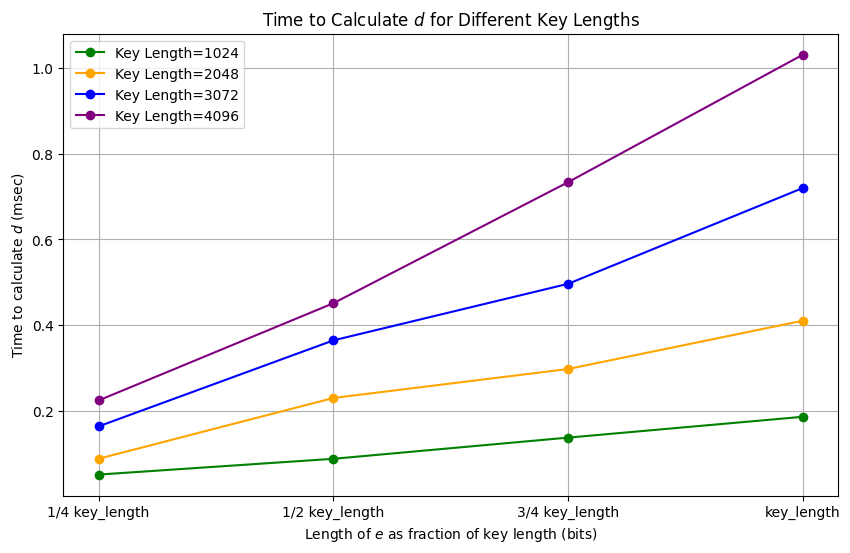

In [27]:
e_lengths = [1/4, 1/2, 3/4, 1]

plt.figure(figsize=(10, 6))
plt.plot(e_lengths, performance_per_key_length[0], marker='o', color="green", label=f'Key Length=1024')
plt.plot(e_lengths, performance_per_key_length[1], marker='o', color="orange", label=f'Key Length=2048')
plt.plot(e_lengths, performance_per_key_length[2], marker='o', color = "blue", label=f'Key Length=3072')
plt.plot(e_lengths, performance_per_key_length[3], marker='o', color = "purple", label=f'Key Length=4096')
plt.xlabel("Length of $e$ as fraction of key length (bits)")
plt.ylabel("Time to calculate $d$ (msec)")
plt.title('Time to Calculate $d$ for Different Key Lengths')
plt.xticks(e_lengths, ["1/4 key_length", "1/2 key_length", "3/4 key_length", "key_length"])
plt.legend()
plt.grid(True)
plt.show()

#### 5.2.4 How does the message block length affect the performance of RSA encryption and decryption?

Previously, we discussed that RSA encryption operates on block chunks (🔴LINK TO SECTION), and the size of these blocks depends on the length of $n$. However, in the trivial implementation (🔴LINK TO SECTION) we provided earlier, we divided the message into individual characters. Let's now explore how dividing the message into larger chunks would impact the time required for encryption and decryption.

##### Divide message into blocks before encrypting

In [28]:
def string_to_ascii_number(string):
    ascii_nums = [ord(char) for char in string]
    # Convert each number to a string with leading zeros if it's a 2-digit number
    ascii_strings = [f"{num:03d}" if num < 100 else str(num) for num in ascii_nums]
    number_as_string = "".join(ascii_strings)
    return int(number_as_string)

def ascii_number_to_string(number):
    number_as_string = str(number)
    if (len(number_as_string) % 3 != 0):
        number_as_string = "0" + number_as_string
    # Split number_as_string into groups of 3 characters
    ascii_chars = [number_as_string[i:i+3] for i in range(0, len(number_as_string), 3)]
    chars = [chr(int(char)) for char in ascii_chars]
    return "".join(chars)

def number_of_bytes(n):
    if n == 0:
        return 1  # Even 0 takes up one byte
    bit_length = n.bit_length()
    byte_length = (bit_length + 7) // 8  # Divide by 8 and round up
    return byte_length

def message_to_blocks(message, block_length):
    """Split a message in blocks of specified length"""
    return [message[i:i + block_length] for i in range(0, len(message), block_length)]

def encrypt_block(block, e, n):
    ascii_block = string_to_ascii_number(block)
    return pow(ascii_block, e, n)

def decrypt_block(encrypted_block, d, n):
    ascii_block = pow(encrypted_block, d, n)
    return ascii_number_to_string(ascii_block)

def message_to_encrypted_blocks(message, e, n):
    block_length_bytes = (number_of_bytes(n) - 1 ) // 2
    blocks = message_to_blocks(message, block_length_bytes)
    encrypted_blocks = [encrypt_block(block, e, n) for block in blocks]
    return encrypted_blocks

def encrypted_blocks_to_message(encrypted_blocks, d, n):
    decrypted_blocks = [decrypt_block(block, d, n) for block in encrypted_blocks]
    decrypted_message = "".join(decrypted_blocks)
    return decrypted_message

In [29]:
long_text = Path("test_data/a_tale_of_two_cities_760000_chars.txt").read_text()
message_length=10000
message = long_text[:message_length]

e, d, n = generate_keys(prime_length_bits = 1024)

block_length_bytes = (number_of_bytes(n) - 1 ) // 2
# blocks = message_to_blocks(message, block_length_bytes)
# encrypted_blocks = [encrypt_block(block, e, n) for block in blocks]
# decrypted_blocks = [decrypt_block(block, d, n) for block in encrypted_blocks]
# decrypted_message = "".join(decrypted_blocks)

encrypted_message = message_to_encrypted_blocks(message, e, n)
decrypted_message = encrypted_blocks_to_message(encrypted_message, d, n)

print("block_length_bytes:", block_length_bytes)

assert(message == decrypted_message)
print(message_length)

block_length_bytes: 127
10000


##### Performance test for encrypting/decrypting messages of various lengths

In [30]:
# this cell runs for ~1min
long_text = Path("test_data/a_tale_of_two_cities_760000_chars.txt").read_text()
e, d, n = generate_keys(prime_length_bits = 1024)
message_lengths = [1000, 2000, 3000, 5000, 10000, 20000]
input_messages = [long_text[:n] for n in message_lengths]
encrypted_messages = [message_to_encrypted_blocks(message, e, n) for message in input_messages]

times_to_encrypt = [mean_time_msec(3)(message_to_encrypted_blocks)(message, e, n) for message in input_messages]
times_to_decrypt = [mean_time_msec(3)(encrypted_blocks_to_message)(encrypted_message, d, n) for encrypted_message in encrypted_messages]

print(times_to_encrypt)
print(times_to_decrypt)

[181.18036666419357, 364.42876667327556, 546.4047666755505, 912.7973000092121, 1805.6606666844648, 3621.465466664328]
[184.2840666649863, 367.8589000094992, 559.6531999957127, 935.9297666621084, 1807.3499333501484, 3617.5360999962627]


##### Plot the results

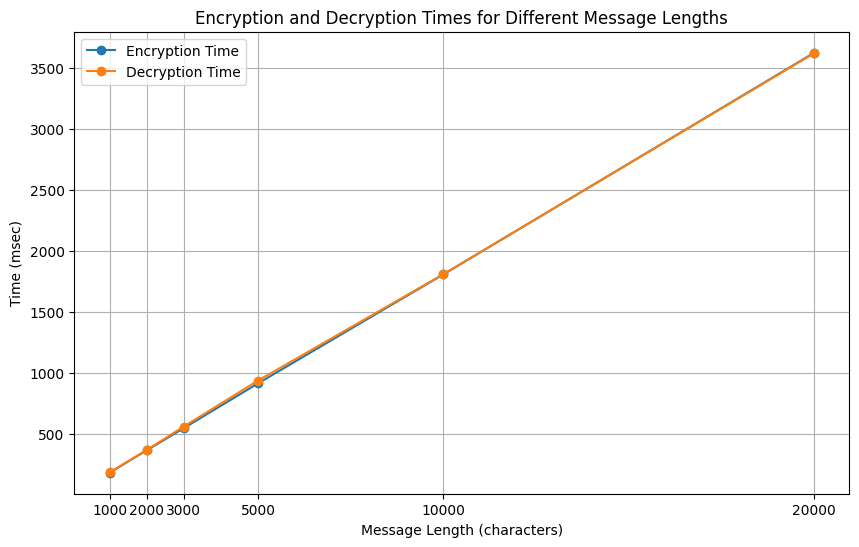

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(message_lengths, times_to_encrypt, marker='o', label='Encryption Time')
plt.plot(message_lengths, times_to_decrypt, marker='o', label='Decryption Time')

plt.xlabel("Message Length (characters)")
plt.ylabel("Time (msec)")
plt.title("Encryption and Decryption Times for Different Message Lengths")
plt.xticks(message_lengths)
plt.legend()
plt.grid(True)
plt.show()

The graph illustrates that the time required for encryption and decryption does not differ. Additionally, the plot shows a linear increase in the time taken as the length of the input message increases. Moving forward, we can incorporate the size of the cryptographic key as an additional variable in the performance testing to analyze how it impacts the encryption and decryption times.

#### 5.2.5 How does key size impact encryption and decryption times?

##### Performance test

In [32]:
message = long_text[:10000]
key_lengths = [256, 512, 1024, 2048]

# list of tuples (e, d, n)
rsa_params = [generate_keys(prime_length_bits = key_length // 2) for key_length in key_lengths]

encrypted_messages = [message_to_encrypted_blocks(message, e, n) for (e, d, n) in rsa_params]
times_to_encrypt = [mean_time_msec(1)(message_to_encrypted_blocks)(message, e, n) for (e, d, n) in rsa_params]
times_to_decrypt = [mean_time_msec(1)(encrypted_blocks_to_message)(encrypted_message, d, n) for encrypted_message, (e, d, n) in zip(encrypted_messages, rsa_params)]
print(times_to_encrypt)
print(times_to_decrypt)


[93.56540004955605, 201.8821999663487, 578.3998999977484, 1839.0277000144124]
[102.14039997663349, 215.53669997956604, 576.5107999905013, 1840.0079000275582]


##### Plot the results

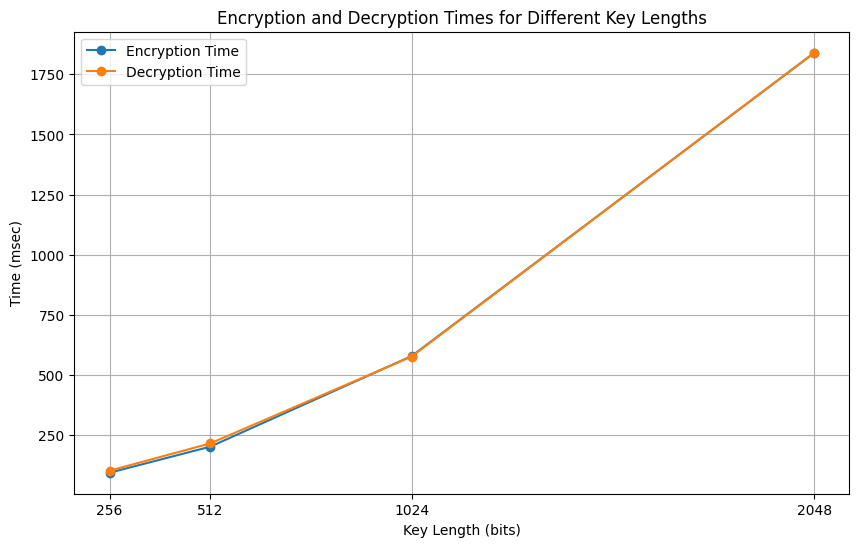

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(key_lengths, times_to_encrypt, marker='o', label='Encryption Time')
plt.plot(key_lengths, times_to_decrypt, marker='o', label='Decryption Time')
plt.xlabel("Key Length (bits)")
plt.ylabel("Time (msec)")
plt.title("Encryption and Decryption Times for Different Key Lengths")
plt.xticks(key_lengths)
plt.legend()
plt.grid(True)
plt.show()

The data shows that as the length of the cryptographic key becomes larger, the time required for the encryption process increases exponentially. Additionally, consistent with the previous graph, we observe that the times taken for encryption and decryption operations are equivalent.